In [ ]:
!pip install gmft -q

We will be downloading a bunch of articles to demonstrate bulk extraction. They are all open access articles with permissive licenses. We will be using them unmodified. Please see sources in the below table.



| doi                                  | Title                                                                                                                                                     | Author        | Notes                                           | Url                                                                       | License                                                     |
|--------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|---------------|-------------------------------------------------|---------------------------------------------------------------------------|-------------------------------------------------------------|
| 10.1007/s13201-023-02046-6           | Synthesis of a nanocomposite with holocellulose extracted from barley straw and montmorillonite, and optimization of the removal of methylene blue dye using the synthesized adsorbent | Farzi et al.  |                                                 | [Link](https://link.springer.com/content/pdf/10.1007/s13201-023-02046-6.pdf)  | CC BY 4.0   |
| 10.1007/s40268-021-00343-6           | Population Pharmacokinetic Model of N-acetylmannosamine (ManNAc) and N-acetylneuraminic acid (Neu5Ac) in Subjects with GNE Myopathy                          | Wart et al.   |                                                 | [Link](https://link.springer.com/content/pdf/10.1007/s40268-021-00343-6.pdf)  | CC BY 4.0   |
| 10.1038/s41467-023-38544-z           | Approaching enzymatic catalysis with zeolites or how to select one reaction mechanism competing with others                                                | Ferri et al.  | alternating table style                        | [Link](https://www.nature.com/articles/s41467-023-38544-z.pdf)               | CC BY 4.0   |
| 10.1038/srep17787                    | Deciphering Genomic Underpinnings of Quantitative MRI-based Radiomic Phenotypes of Invasive Breast Carcinoma                                               | Zhu et al.    | image table and difficult table with uneven columns | [Link](https://www.nature.com/articles/srep17787.pdf)                        | CC BY 4.0   |
| 10.1107/s2052252519008285            | Catalytically important damage-free structures of a copper nitrite reductase obtained by femtosecond X-ray laser and room-temperature neutron crystallography | Halsted et al. |                                                 | [Link](https://journals.iucr.org/m/issues/2019/04/00/ec5013/ec5013.pdf)      | CC BY 4.0                                                   |
| 10.1186/s12284-023-00656-x           | The Inferior Grain Filling Initiation Promotes the Source Strength of Rice Leaves                                                                          | Jiang et al.  |                                                 | [Link](https://thericejournal.springeropen.com/counter/pdf/10.1186/s12284-023-00656-x.pdf) | CC BY 4.0   |
| 10.1186/1471-2334-11-124             | Core mutations, IL28B polymorphisms and response to peginterferon/ribavirin treatment in Swedish patients with hepatitis C virus genotype 1 infection      | Alestig et al.| very large table                                | [Link](https://bmcinfectdis.biomedcentral.com/counter/pdf/10.1186/1471-2334-11-124.pdf)    | CC BY 2.0                                                   |
| 10.48550/arXiv.2211.13344            | Solubility of water in peridotite liquids and the prevalence of steam atmospheres on rocky planets                                                         | Sossi et al.  | vertical table                                  | [Link](https://arxiv.org/pdf/2211.13344)                                        | CC BY 4.0   |
| 10.1007/s00216-012-6627-x | Cellobiose dehydrogenase modified electrodes: advances by materials science and biochemical engineering | Ludwig et al. | vertical tables, many tables | [Link](https://link.springer.com/content/pdf/10.1007/s00216-012-6627-x.pdf) | CC BY |


1.pdf - 10.1007/s13201-023-02046-6 - no pmcid - not in train
2.pdf - 10.1007/s40268-021-00343-6 - pmc8206310 - not in train
3.pdf - 10.1038/s41467-023-38544-z - pmc10198988 - not in train
4.pdf - 10.1038/srep17787 - pmc4671006 - not in train set
5.pdf - 10.1107/s2052252519008285 - pmc6608623 - not in train
6.pdf - 10.1186/s12284-023-00656-x - no pmcid - not in train
7.pdf - 10.1186/1471-2334-11-124 - pmc3112098 - **IS in train set**
8.pdf - 10.48550/arXiv.2211.13344 - no pmcid - not in train
9.pdf - 10.1007/s00216-012-6627-x - pmc3608873 - not in train

In [ ]:
!mkdir ./bulk
!wget -O bulk/1.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s13201-023-02046-6.pdf
!wget -O bulk/2.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s40268-021-00343-6.pdf
!wget -O bulk/3.pdf bulk -q https://www.nature.com/articles/s41467-023-38544-z.pdf
!wget -O bulk/4.pdf bulk -q https://www.nature.com/articles/srep17787.pdf
!wget -O bulk/5.pdf bulk -q https://journals.iucr.org/m/issues/2019/04/00/ec5013/ec5013.pdf
!wget -O bulk/6.pdf bulk -q https://thericejournal.springeropen.com/counter/pdf/10.1186/s12284-023-00656-x.pdf
!wget -O bulk/7.pdf bulk -q https://bmcinfectdis.biomedcentral.com/counter/pdf/10.1186/1471-2334-11-124.pdf
!wget -O bulk/8.pdf bulk -q https://arxiv.org/pdf/2211.13344
!wget -O bulk/9.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s00216-012-6627-x.pdf

It is sometimes convenient to only extract tables with certain keywords.

In [3]:
import json
import re
# language=RegExp
page_keywords_re_s = [re.compile(x, re.IGNORECASE) for x in \
                    [r'\btables?\b']]

# table_keywords_re_s = [re.compile(x, re.IGNORECASE) for x in \
                    # [r'\bGDP\b' r'per capita', r'interest rates?', r'$']]


In [4]:
from gmft import CroppedTable, AutoTableDetector, AutoTableFormatter
from gmft.pdf_bindings import PyPDFium2Document

detector = AutoTableDetector()
formatter = AutoTableFormatter()

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        page_text = ""
        for text in page.get_positions_and_text():
            page_text += text[4] + " "
        if any([re.search(x, page_text) for x in page_keywords_re_s]):
            tables += detector.extract(page)
    return tables, doc


First, test it out on a document of your choice.

In [9]:
tables, doc = ingest_pdf("bulk/1.pdf")

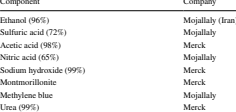

In [10]:
tables[0].image()

In [13]:
!mkdir results
!mkdir results/false_positives

mkdir: cannot create directory ‘results’: File exists


In [12]:
import os
from tqdm import tqdm

root = "bulk"
save_dir = "results"

last_processed = None # list(os.listdir(root))[4020]

You will need to `!mkdir /path/to/destination/folder/false_positives`.

In [ ]:
last_processed

In [14]:
for filename in tqdm(sorted(os.listdir(root))):
    if last_processed is not None and filename < last_processed:
        continue
    if filename.endswith(".pdf"):
        filename = filename[:-4]
        # check if folder exists
        if os.path.exists(f"{save_dir}/{filename}"):
            continue

        # ingest pdf
        doc = None
        try:
            tables, doc = ingest_pdf(f"{root}/{filename}.pdf")
            exists = False
            for i, table in enumerate(tables):
                # check for keywords presence again
                # text = table.text()
                # if not any([re.search(x, text) for x in table_keywords_re_s]):
                    # continue

                # count number of numerical values in text, because we are getting false-positive reference sections
                # these false-positives are almost always when the table is rotated
                if table.label == 1:

                #     num_numerical = 0
                #     for x in text:
                #         if x.isdigit():
                #             num_numerical += 1
                #     # only process "tables" with num_numerical > 20% of characters, b/c of false positive incidence
                #     num_nonnumerical = len(text) - num_numerical
                #     if num_nonnumerical / len(text) >= 0.8 and num_nonnumerical >= 1500:
                #         # print(num_nonnumerical)
                #         table.image(dpi=36).save(f"{save_dir}/false_positives/{filename}_{i}.png")
                #         json.dump(table.to_dict(), open(f"{save_dir}/false_positives/{filename}_{i}.info.json", "w"))
                #     else:
                    if not exists:
                        # make folder
                        os.makedirs(f"{save_dir}/{filename}")
                        exists = True
                    table.image(dpi=144).save(f"{save_dir}/{filename}/{i}_rotated.png")
                    json.dump(table.to_dict(), open(f"{save_dir}/{filename}/{i}_rotated.info.json", "w"))
                    continue
                if not exists:
                    # make folder
                    os.makedirs(f"{save_dir}/{filename}")
                    exists = True
                try:
                    ft = formatter.extract(table)
                    # write image, csv, and info to {save_dir}/{filename}/{table_no}.{png,csv,info.json}
                    ft.image(dpi=144).save(f"{save_dir}/{filename}/{i}.png")
                    ft.df().to_csv(f"{save_dir}/{filename}/{i}.csv", index=False)
                    # this includes, for instance, outlier info
                    json.dump(ft.to_dict(), open(f"{save_dir}/{filename}/{i}.info.json", "w"))
                except Exception as e:
                    print(f"Error processing {filename}, {i}, {e}")
        except Exception as e:
            print(f"Error processing {filename}, {e}")
            # do NOT continue
        finally:
            if doc is not None:
                doc.close()

        
        last_processed = filename

  0%|          | 0/8 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [00:31<00:09,  4.82s/it]

Invoking large table row guess! set TATRFormatConfig.large_table_threshold to 999 to disable this.


100%|██████████| 8/8 [00:38<00:00,  4.82s/it]


(Note that filtering by keywords may speed up inference.)

,Component,Company
0,Ethanol (96%),Mojallaly (Iran)
1,Sulfuric acid (72%),Mojallaly
2,Acetic acid (98%),Merck
3,Nitric acid (65%),Mojallaly
4,Sodium hydroxide (99%),Merck
5,Montmorillonite,Merck
6,Methylene blue,Mojallaly
7,Urea (99%),Merck


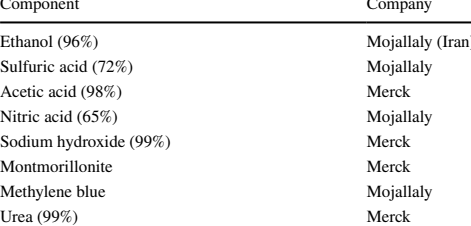

,Factor Complete name,Coded name,Levels Range,−1,0,1
0,Temperature (°C),x1,25–35,25,30,35
1,pH,x2,4–8,4,6,8
2,Initial dye concen￾tration (mg L−1),x3,4–8,4,6,8
3,Mesh size,x4,50–150,50,100,150


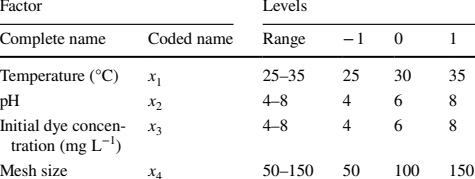

,Adsorbent,Specifc surface area (m2 g−1),Total pore vol￾ume (cm3 g−1),Average particle size (nm)
0,HCMM,25.147,8.635,84.172


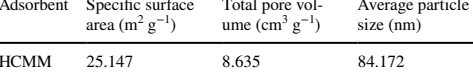

,Run,x1: T (°C),x2: pH,x3: MB initial concen￾tration (mg L−1),x4: Mesh size,MB removal (%)
0,1,25,8,4,150,84.90
1,2,30,6,6,100,89.31
2,3,30,6,4,100,90.71
3,4,30,6,6,50,91.09
4,5,30,6,6,100,89.34
5,6,25,8,8,50,87.38
6,7,30,8,6,100,92.12
7,8,30,4,6,100,87.16
8,9,35,8,4,50,92.14
9,10,35,4,8,50,85.56


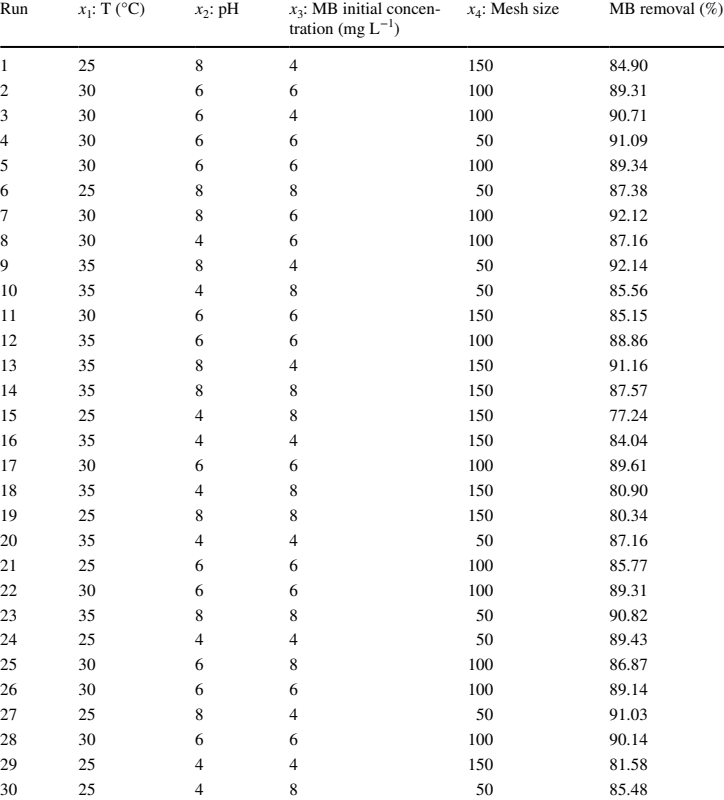

,Source,DF,Adjusted SS,Adj MS,F value,p value
0,Model,14,401.025,28.6446,218.33,0.0
1,x1,1,6.457,6.4568,49.21,0.0
2,x2,1,2.068,2.068,15.76,0.001
3,x3,1,0.014,0.0141,0.11,0.748
4,x4,1,2.209,2.209,16.84,0.001
5,x2 1,1,10.26,10.2603,78.2,0.0
6,x2 2,1,0.291,0.2908,2.22,0.157
7,x2 3,1,0.687,0.6872,5.24,0.037
8,x2 4,1,3.638,3.6382,27.73,0.0
9,x1x2,1,12.443,12.4433,94.84,0.0


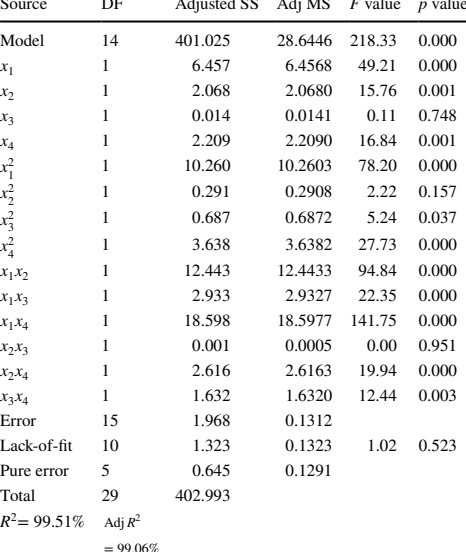

,Adsorbent(s),Adsorbent dosage (g/L),Removal percentage,Reference
0,HCMM,1,77.24–95.14,This work
1,Activated carbon from Rumex abyssinicus plant,0.2–0.6,82.16–99.96,Fito et al. (2023)
2,Barley straw and corn stalks modifed by citric...,6–14,48–97,Soldatkina & Yanar (2023)
3,Activated carbon from Scrap Tire,2.5,89.18–90.48,Kassahun et al. (2022)
4,Barley Bran and Enset Midrib Leaf,2.5,96–98,Mekuria et al. (2022)
5,Raspberry (Rubus idaeus) leaves powder,1–5,30–44,Mosoarca et al. (2022)
6,Activated carbon from grape leaves waste,0.25–12.25,0–97.4,Mousavi et al. (2022a)
7,Activated carbon from grape wood wastes,0.25–12.25,0–95.66,Mousavi et al. (2022b)
8,Black tea wastes,13.3,30–72,Ullah et al. (2022)
9,Carboxymethyl cellulose grafted by polyacrylic...,100,38–97,Hosseini et al. (2022)


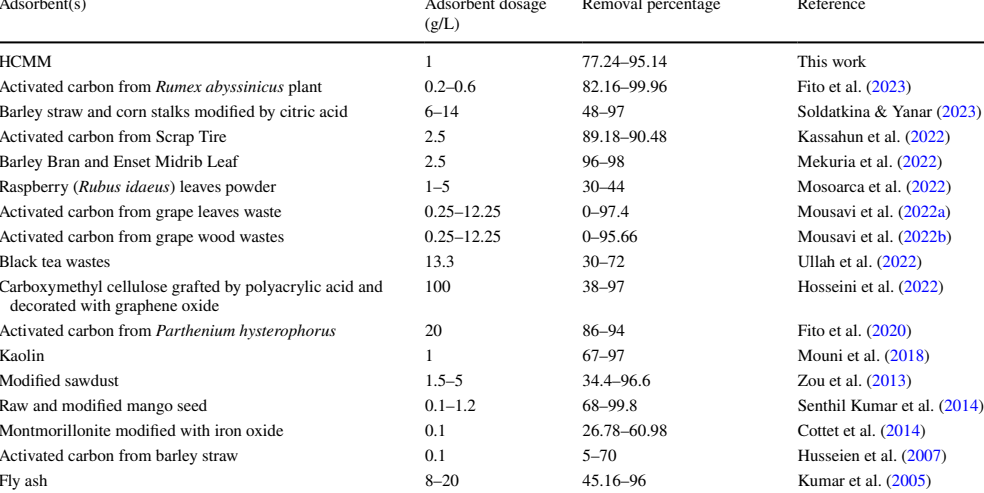

,Variable,Optimum value
0,Initial concentration of dye (mg L−1),4.00
1,Temperature (°C),32.00
2,pH,8.00
3,Adsorbent mesh size,70.00
4,Predicted removal percentage,93.91
5,Experimental removal percentage at optimal con...,95.14


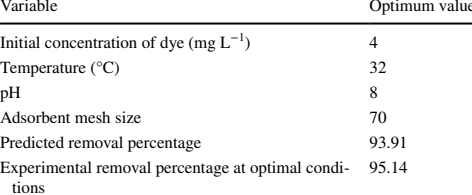

,Model,Parameters,Unnamed: 2
0,Langmuir,qm(mg g−1),159
1,,kL(L mg−1),0.0956
2,,R2,0.984
3,Freundlich,n,2.52
4,,kF(mg g−1),26.42
5,,R2,0.891
6,Temkin,B,29.245
7,,kT(L mg−1),1.518
8,,b(J g mg−1 mol−1),87
9,,R2,0.970


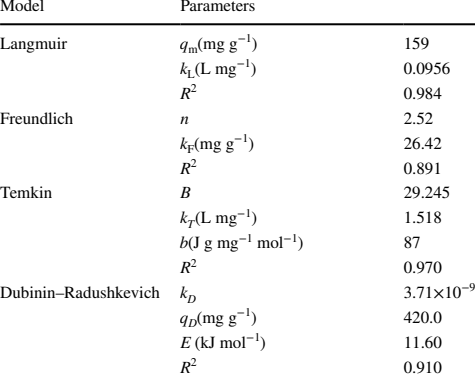

,Kinetic model,Parameters,Unnamed: 2
0,Linear driving force,k1(min−1),0.0604
1,,"qe,calc(mg g−1)",22.3900
2,,"qe,exp(mg g−1)",54.2800
3,,R2,0.9270
4,Pseudo-second-order,"qe,calc(mg g−1)",55.5700
5,,k2(g.mg−1 min−1),0.0180
6,,R2,0.9990
7,Intra-particle difusion,"k3,1(mg g−1 min−0.5)",1.7660
8,,I1(mg g−1),39.3600
9,,R2 1,0.9920


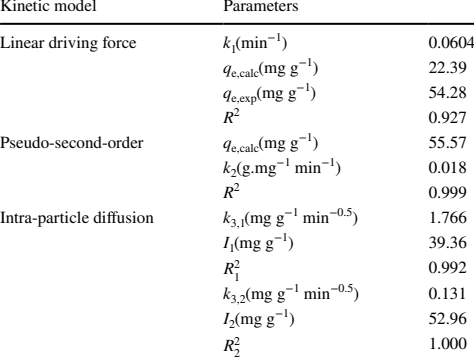

,Stage of phar￾macokinetic modeling,Data utilized,Modeling activities
0,Stage 1,ManNAc single dose pharmacokinetic data (Study...,Design of structural pharmacokinetic model Exp...
1,Stage 2,ManNAc BID pharmacokinetic data (Study 15-HG-0...,Covariate analysis Determination of non-linear...
2,Stage 3,Stage 2 population pharmacokinetic model for M...,Monte Carlo simulations of dosing regimens Rec...
3,Stage 4,"All available data, including the additional T...",Finalize pharmacokinetic model


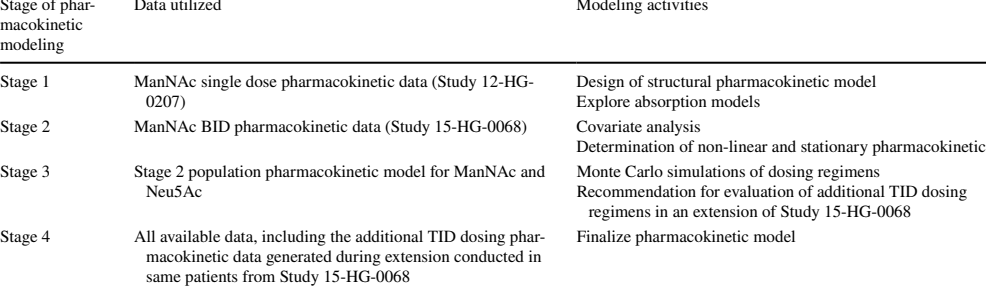

,Variable,N (%),Mean,SD,Median,Min,Max,is_spanning_row
0,Age (years),34,41.3,10.4,39.5,25.0,65.0,False
1,Weight (kg),34,83.5,20.2,84.6,49.3,115.0,False
2,Height (cm),34,173.0,13.3,172.0,151.0,197.0,False
3,BMI (kg/m2 ),34,27.6,4.7,27.2,19.1,39.8,False
4,BSA (m2 ),34,2.01,0.31,2.06,1.45,2.5,False
5,eGFR (mL/min)a,34,123.0,22.2,120.0,85.0,170.0,False
6,Albumin (g/dL),34,3.83,0.403,3.8,3.2,4.8,False
7,Serum creatinine (mg/dL),34,0.499,0.223,0.49,0.12,0.95,False
8,Creatine kinase (U/L),34,236.0,124.0,220.0,44.0,556.0,False
9,Sex,,,,,,,False


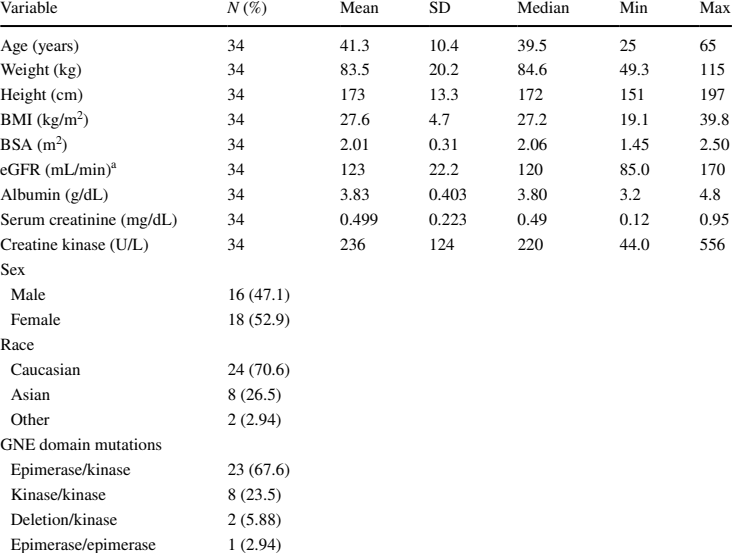

,ManNAc dose,Q8H for 30 Median,days 5th–95th percentiles,Q12H for 30 Median,days 5th–95th percentiles.1,Q24H for Median,30 days 5th–95th percentiles,is_spanning_row
0,Plasma ManNAc,"Css,ave (ng/mL)",,,,,,False
1,3 g,922,501–1550,642.0,359–1060,365.0,223–570,False
2,4 g,1060,573–1790,729.0,404–1220,411.0,246–650,False
3,6 g,1290,692–2180,881.0,480–1480,483.0,281–780,False
4,10 g,1650,883–2810,1120.0,607–1900,603.0,340–989,False
5,Plasma Neu5Ac,"Css,ave (ng/mL)",,,,,,True
6,3 g,633,247–2010,484.0,209–1420,338.0,174–825,False
7,4 g,702,265–2300,533.0,222–1610,364.0,181–921,False
8,6 g,818,296–2780,612.0,242–1930,405.0,190–1080,False
9,10 g,1020,344–3540,735.0,274–2440,464.0,204–1330,False


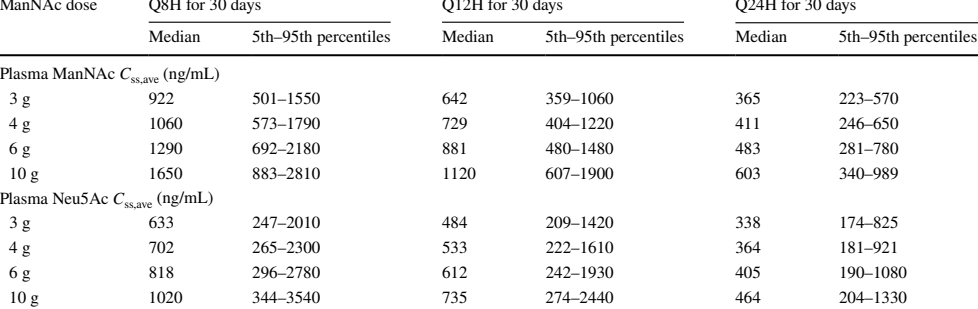

,Parameter,Final typical value estimate,%SEM,is_spanning_row
0,ka (h−1),0.256,15.2,False
1,CLM/F (L/h),631,14.8,False
2,VM/F (L),506,29.4,False
3,M0 (ng/mL),61.1,12.0,False
4,N0 (ng/mL),150,5.71,False
5,kout (h−1),0.283,5.65,False
6,SLP0 (ng/mL)−1,0.000619,29.1,False
7,SLPSS (ng/mL)−1,0.00334,35.0,False
8,kinc (h−1),0.0287,45.3,False
9,tlag (h),0.254,26.4,False


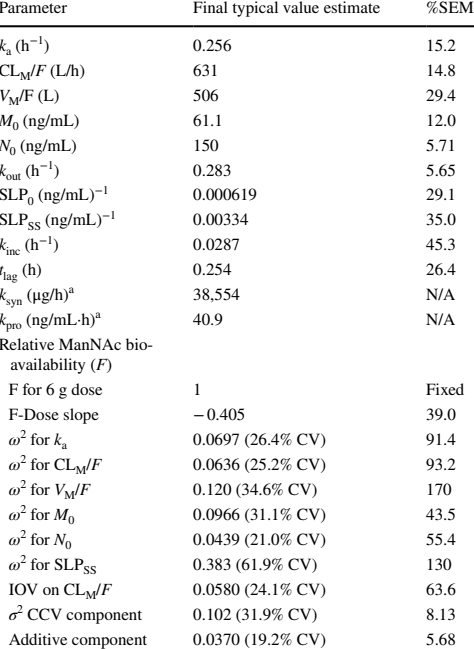

,Unnamed: 0,Channels system,n,Itrans (kJ/mol),Idisp (kJ/mol),Idisp /Itrans
0,BEA,12 × 12 × 12,3,−148,−129,0.87
1,BEC,12 × 12 × 12,1,−123,−151,1.22
2,BOG,12 × 10 × 10,4,−140,−140,1.00
3,CON,12 × 10 × 10,2,−132,−149,1.14
4,FAU,12 × 12 × 12,7,−104,−106,1.02
5,ITT,18 × 10 × 10,4,−110,−155,1.41
6,IWR,12 × 10 × 10,1,−145,−174,1.20
7,IWV,12 × 12,2,−102,−90,0.88
8,MOR,12 × 8,2,−141,−104,0.74
9,SEW,12 × 10,2,−160,−188,1.18


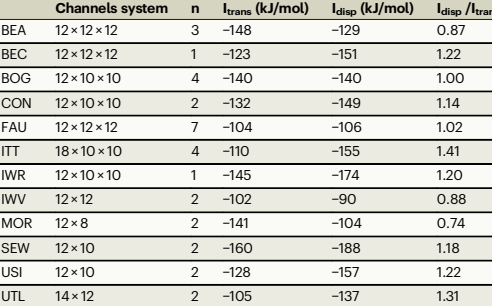

,Unnamed: 0,Channels system,Ea1,Ea2,Ea3,Ea4,Ea5,Ea6,is_spanning_row
0,transalkylation,,,,,,,,True
1,BEC,12 × 12 × 12,98.0,35.0,44.0,48.0,85.0,98.0,False
2,BOG,12 × 10 × 10,75.0,29.0,65.0,50.0,88.0,96.0,False
3,IWR,12 × 10 × 10,71.0,31.0,60.0,44.0,91.0,90.0,False
4,IWV,12 × 12,56.0,21.0,52.0,47.0,60.0,86.0,False
5,MOR,12 × 8,95.0,33.0,78.0,50.0,84.0,87.0,False
6,UTL(int),14 × 12,59.0,29.0,49.0,49.0,82.0,97.0,False
7,UTL(cha),14 × 12,64.0,28.0,57.0,45.0,68.0,80.0,False
8,disproportionation,,,,,,,,False
9,BEC,12 × 12 × 12,113.0,30.0,56.0,55.0,78.0,118.0,False


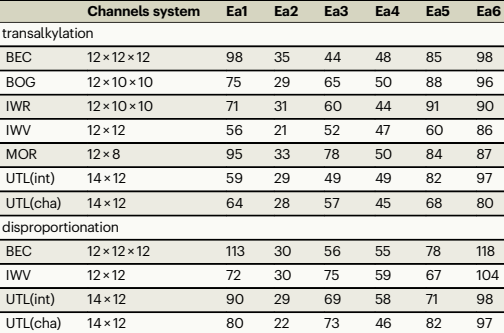

,zeolite,IZA code,DEB conv. (%),rtrans (molEB/molacidh),EB (%),TEB (%),C2H4 (%),HP (%),Eaa (kJ/mol)
0,ITQ-33,ITT,11.9,717,76.4,20.8,0.6,2.1,75.2
1,ITQ-15,UTL,17.7,1599,85.7,12.0,0.0,2.3,56.1
2,USY,FAU,14.7,1075,90.1,2.7,2.7,4.5,66.5
3,ITQ-17,BEC,20.8,628,88.8,8.3,0.5,2.3,59.5
4,ITQ-27,IWV,14.9,1926,94.1,0.5,2.3,3.0,58.3
5,ITQ-24,IWR,15.2,676,95.1,2.5,0.4,2.0,69.4
6,ITQ-47,BOG,14.4,349,90.4,4.4,4.8,0.4,66.2
7,mordenite,MOR,9.6,279,88.6,2.5,4.6,4.2,74.2


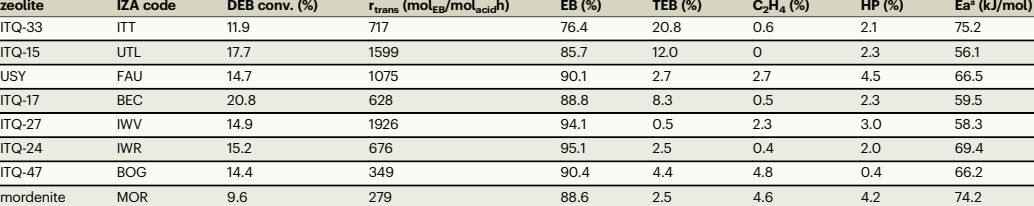

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6


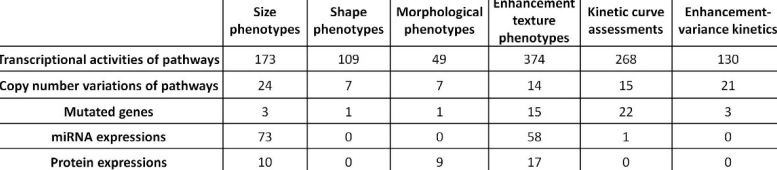

,Data Platform,Unnamed: 1,Number of Features,Unnamed: 3,Number of tumors,is_spanning_row
0,Number of features and tumors,in different data,platforms,,,False
1,Radiomics,,38,,91,False
2,Gene expressions,20531,genes (186,pathways),91,False
3,Copy number variations,19950,genes (186,pathways),91,False
4,miRNA expressions,,1046,,91,False
5,Protein expressions,,142,,62,False
6,Mutated genes,,3734,,91,False
7,,,,,,True
8,Number of tumors with different,pathological,stages,,,True
9,,,,,,False


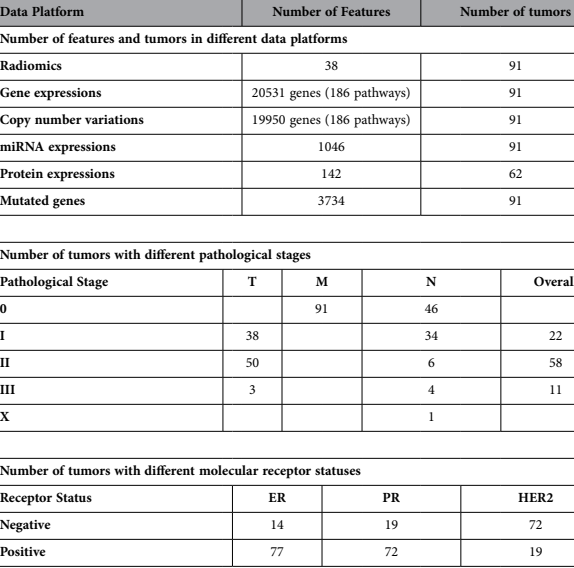

,Unnamed: 0,SF-ROXOX,SF-ROXNIT,SF-ROXRED,is_spanning_row
0,No. of crystals,75,62,33,False
1,Images collected,1867,1257,581,False
2,Images merged Data collection,1377,1039,410,False
3,Space group,P213,P213,P213,False
4,a = b = c (A˚ ),94.95,94.92,94.61,False
5, =  =  ( ),90,90,90,False
6,Resolution (A˚ ),54.82–1.50,54.80–1.50,54.62–1.60,False
7,,(1.54–1.50),(1.54–1.50),(1.64–1.60),False
8,Rsplit† (%),11.5 (90.4),10.6 (85.3),15.8 (70.8),False
9,,,,,False


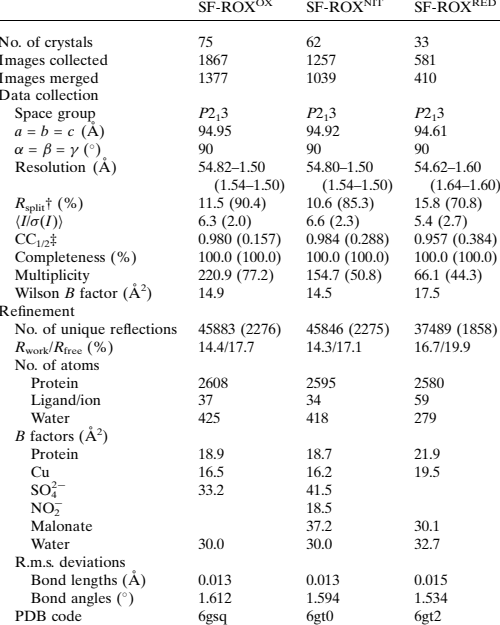

,Unnamed: 0,Unnamed: 1,is_spanning_row
0,Data collection,,False
1,Wavelength range (A˚ ),3.05–4.00,False
2,No. of images,20,False
3,Setting spacing (),7,False
4,Average exposure time (h),18,False
5,Space group,P213,False
6,a = b = c (A˚ ),97.98,False
7, =  =  ( ),90,False
8,Resolution (A˚ ),40–1.80 (1.90–1.80),False
9,Rp.i.m. (%),6.3 (12.7),False


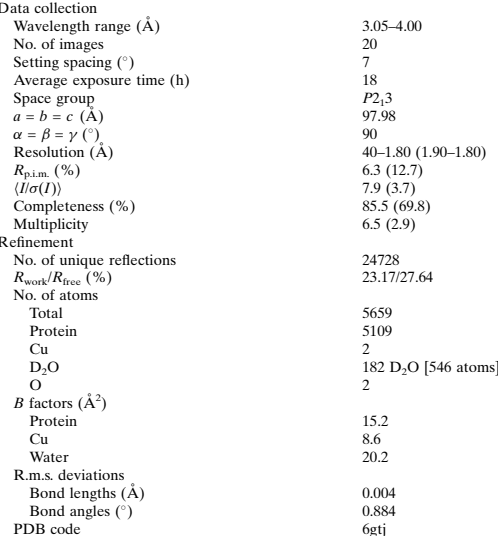

,Year,Variety,Treatment,Spikelets per panicle,1000-grain weight (g),Seed setting rate (%),Unnamed: 6
0,2019,CJ03,T0,267.67a,21.87c,87.67c,
1,,,T1,91.17b,20.10d,93.00b,
2,,W1844,T0,275.67a,22.91b,84.92d,
3,,,T1,97.92b,25.95a,95.58a,
4,2020,CJ03,T0,259.75a,22.38c,92.25b,
5,,,T1,77.50c,20.97d,94.17a,
6,,W1844,T0,273.67a,24.35b,85.17c,
7,,,T1,92.58b,25.19a,94.67a,
8,Year,Variety,Treatment,SG per panicle,IG per panicle,SG rate (%),IG rate (%)
9,2019,CJ03,T0,104.65a,163.02b,39.10a,60.90b


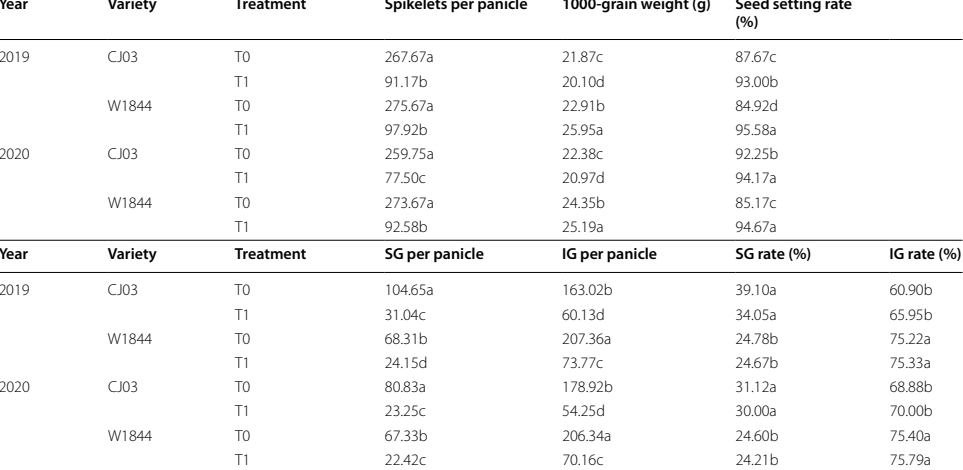

,Year,Variety,Treatment,Net photosynthetic rate (umol·m−2 s−1 ),Stomatal conductance (mmol·m−2 s−1 ),Intercellular CO2 concentration (μmol·mol−1 ),Trmmol rate (mmol·m−2 s−1 )
0,2019.0,CJ03,T0,22.51a,0.65b,285.30b,6.53a
1,,,T1,20.06c,0.52c,268.55c,5.32c
2,,W1844,T0,21.91a,0.74a,305.32a,6.28a
3,,,T1,20.72b,0.60bc,274.15b,5.68b
4,2020.0,CJ03,T0,25.40a,0.86a,225.50ab,13.73a
5,,,T1,20.92c,0.54c,210.57c,11.72c
6,,W1844,T0,24.91a,0.89a,233.63a,13.78a
7,,,T1,21.92b,0.75b,220.72b,12.71b


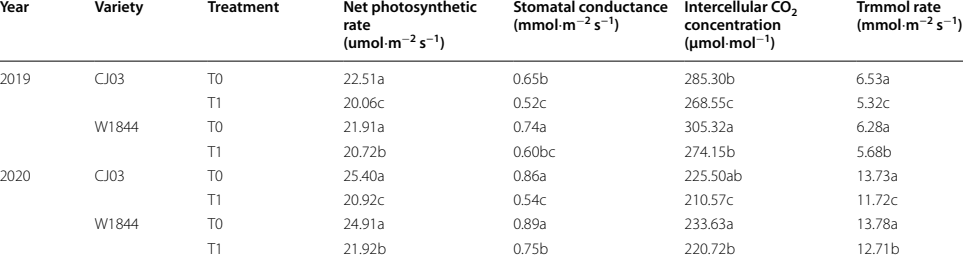

,IS,Inferior spikelets,Unnamed: 2,Unnamed: 3
0,SS,Superior spiklelets,,
1,OsSWEET11,Oryza sativa Sugar will,eventually be exported transporter,11
2,OsSUTs,Oryza sativa Sucrose,transporters,
3,SPS,Sucrose-phosphate,synthase,
4,SuSase,Sucrose synthase,,
5,AGPase,ADP-glucose,pyrophosphorylase,
6,T6P,Trehalose-6-phosphate,,
7,SnRK1,Snf1-related protein,kinase-1,
8,TPS,Trehalose-6-phosphate,synthase,
9,TPP,Trehalsoe-6-phosphate,phosphatase,


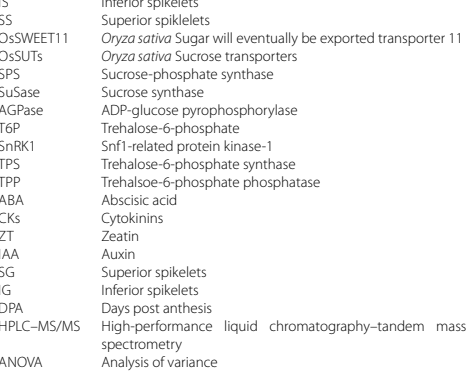

,Patient no,Genotype,Viral load (106 IU/ml),Sex,Age (years),Core 70,amino acid 91,rs12979860,End of treatment response a
0,R1,1a,4.36,M,52.6,R,C,CC,SVR
1,R2,1a,6.37,M,34.9,R,C,CC,SVR
2,R3,1a,7.84,M,45.8,R,C,CC,SVR
3,R4,1a,7.77,F,42.3,R,C,CC,SVR
4,R5,1a,7.05,M,45.3,R,C,CC,SVR
5,R6,1a,7.19,F,45.5,R,C,CC,SVR
6,R7,1a,5.54,F,46.9,R,C,CC,SVR
7,R8,1a,5.46,M,29.1,R,C,CT,SVR
8,R9,1a,6.18,M,50.7,R,C,CC,SVR
9,R10,1a,6.42,M,59.9,R,C,CC,SVR


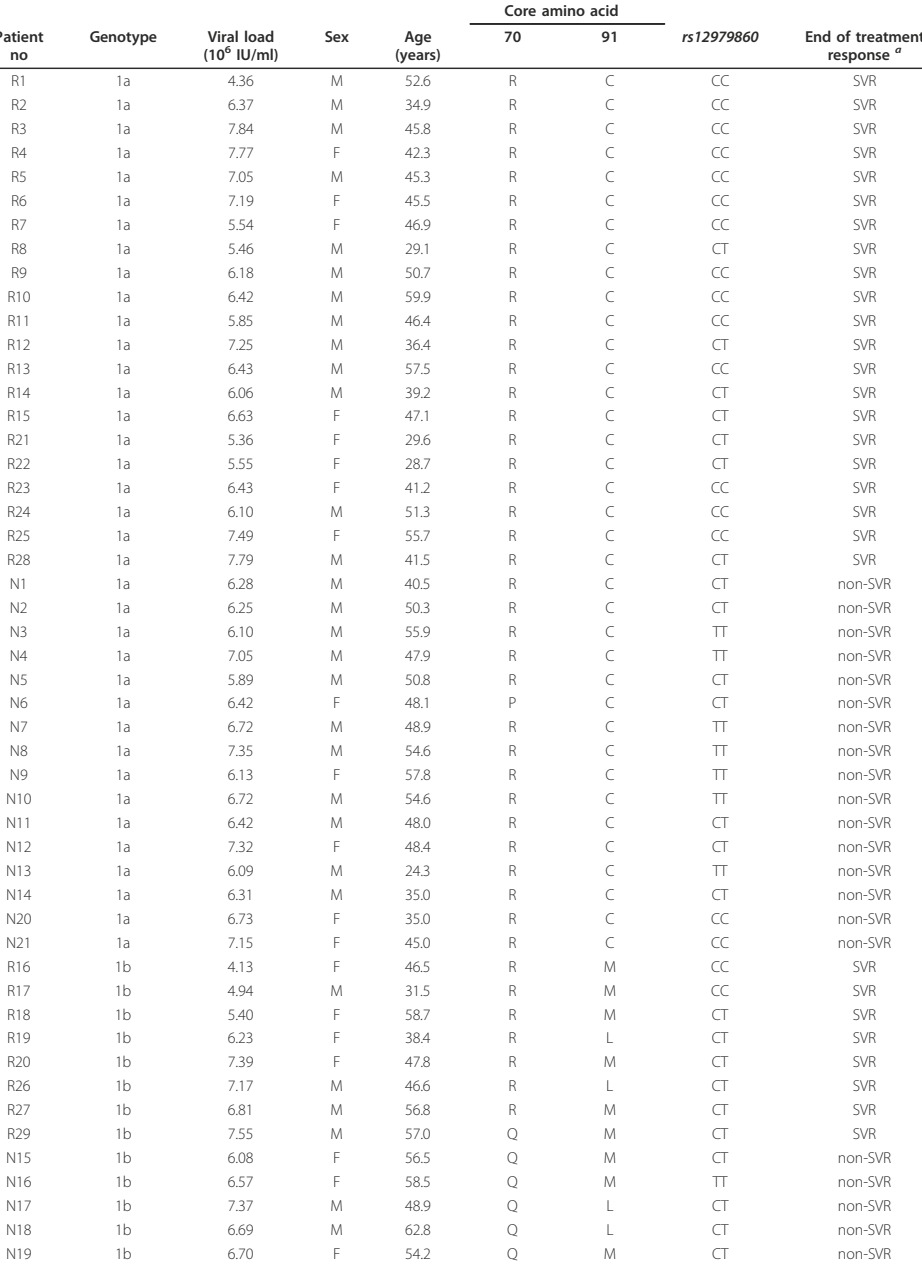

,Unnamed: 0,SVR n = 29,non-SVR n = 21,Univariate p value
0,Age (mean),45.2,48.8,0.09a
1,Number of patients < 45 / > 45 yrs,11 / 18,4 / 17,0.21b
2,Gender (m/f),17 / 12,13 / 8,1.0b
3,Baseline HCV RNA (mean log IU/mL),6.37,6.59,0.56a
4,Number with < 5.6 / > 5.6 log IU/mL,8 / 21,0 / 21,0.01b
5,Genotype 1a/1b,21 / 8,16 / 5,1.0b
6,Fibrosis (F0/F1/F2/F3/F4)c,0 / 10 / 13 / 4 / 0,2 / 4 / 4 / 7 / 2,0.19d
7,Core aa 70,28 R / 1 Q,15 R / 5 Q & 1 P,0.03b
8,Core aa 91,21 C / 6 M / 2 L,16 C / 3 M / 2 L,0.82e
9,rs12979860,16 CC / 13 CT / 0 TT,2 CC / 11 CT / 8 TT,0.0001e


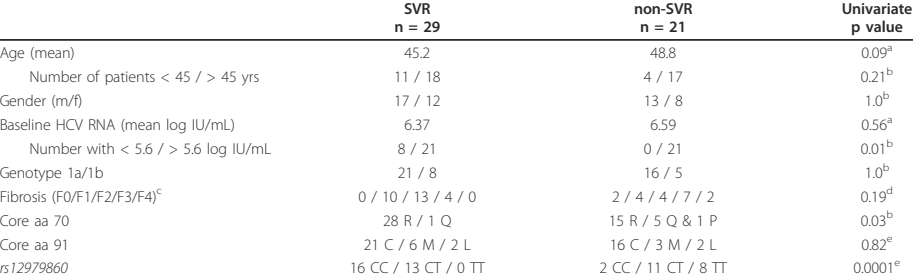

,Genotype,Q,Amino R,acid 70 P,H,Amino C,acid M,91 L,Total
0,1a,2%,98%,-,-,100%,-,-,920
1,1b,60%,35%,-,4%,1%,71%,28%,2022
2,2,-,100%,-,-,39%,4%,58%,83
3,3,-,93%,6%,-,99%,-,-,204
4,4,5%,95%,-,-,100%,-,-,19
5,5,86%,14%,-,-,-,-,100%,14
6,6,60%,13%,13%,15%,100%,-,-,55


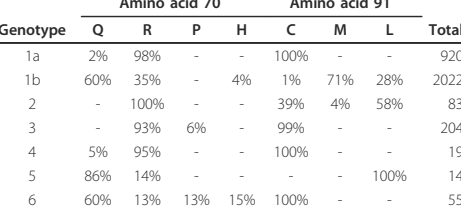

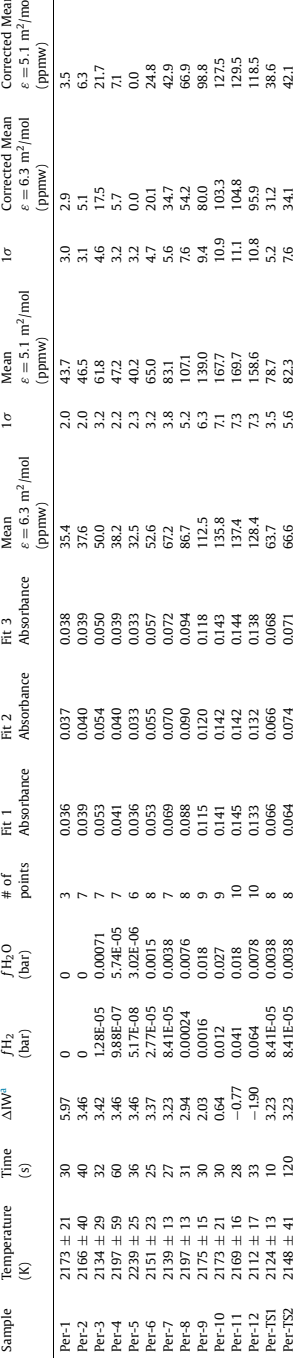

,This work (ε3550 6.3 m2/mol),Peridotite,(K) 2173,Unnamed: 3,(bar−0.5) 2.91 10−3,(bar) 5.7 10−5 0.027,14
0,This work (ε3550 = 5.1 m2/mol),Peridotite,2173,,3.59 × 10−3,5.7 × 10−5 – 0.027,14
1,Newcombe et al. (2017),Anorthite-Diopside eutectic,1623,,4.22 × 10−3,9.8 × 10−3 – 0.32,14
2,Newcombe et al. (2017),Lunar Green Glass,1623,,4.04 × 10−3,9.8 × 10−3 – 0.32,11
3,Dixon et al. (1995),Mid-Ocean Ridge Basalt,1473,,5.36 × 10−3,17 – 709,14
4,Hamilton and Oxtoby (1986),NaAlSi3O8,1123 – 1573,,7.59 × 10−3 – 9.91 × 10−3,1685 – 2160,13


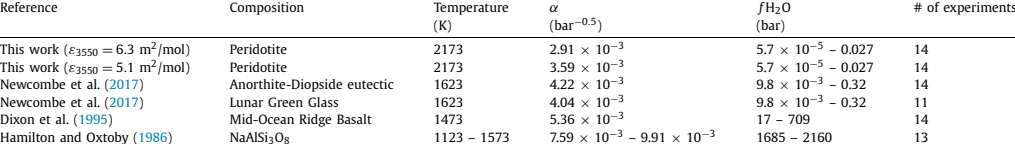

In [17]:
from IPython.display import Image, display
import pandas as pd
for subdir in sorted(os.listdir("results")):
    for filename in sorted(os.listdir(f"results/{subdir}")):
        if filename.endswith(".png"):
            display(Image(f"results/{subdir}/{filename}"))
        elif filename.endswith(".csv"):
            df = pd.read_csv(f"results/{subdir}/{filename}")
            df.fillna("",inplace=True)
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                display(df)

Strengths:
- alignment accuracy
- small and medium size tables
- throughput

Weaknesses: 
- rotated tables (future support)
- multi-indexes
- underlying OCR issues
- uneven columns, as in 4.pdf